In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow as tf 
import tqdm
import glob
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Mendefinisikan fungsi fungsi pada augmentasi data
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

In [3]:
#Mendefinisikan data train dan kemudian melakukan augmentasi
train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\LENOVO\Documents\JENIS PLASTIK',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 10,
                                                   subset = 'training')

Found 242 images belonging to 3 classes.


In [4]:
#Mendefinisikan data valid (test) dan kemudian melakukan augmentasi
valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\LENOVO\Documents\JENIS PLASTIK',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  shuffle = False,
                                                  batch_size = 10,
                                                  subset = 'validation')

Found 60 images belonging to 3 classes.


In [5]:
#Jumlah seluruh dataset
total = train_dataset.samples + valid_dataset.samples
total

302

In [6]:
#Mendefinisikan label
train_dataset.class_indices

{'HDPE': 0, 'LDPE': 1, 'PET': 2}

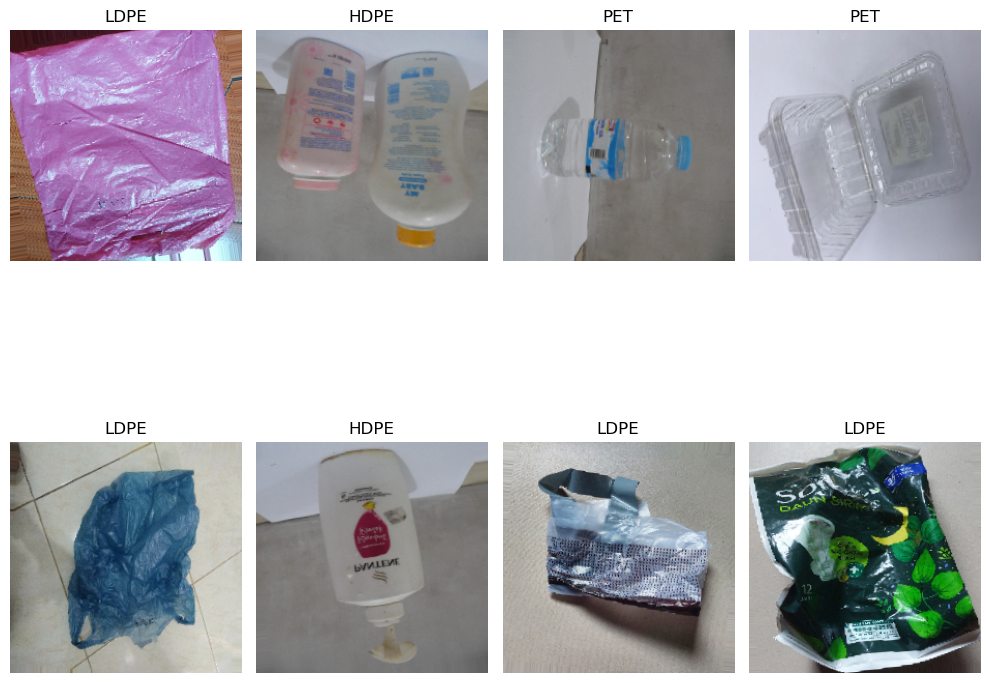

In [10]:
#Plot 5 10 data secara acak
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))

for i in range(2):
    for j in range(4):
        rand1 = np.random.randint(len(train_dataset))
        rand2 = np.random.randint(10)
        ax[i, j].imshow(train_dataset[rand1][0][rand2])
        ax[i, j].axis('off')
        label = train_dataset[rand1][1][rand2]
        class_label = np.argmax(label)  # Get the index of the maximum value in the label array
        if class_label == 0:
            ax[i, j].set_title('HDPE')
        elif class_label == 1:
            ax[i, j].set_title('LDPE')
        else:
            ax[i, j].set_title('PET')

plt.tight_layout()
plt.show()

In [7]:
#Mengambil model pretrained VGG16 dari tensorflow keras
from tensorflow.keras.applications import VGG16


pretrained_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], include_top=False, weights="imagenet")
#Mencegah model dari mengubah bobot pada proses pelatihan
pretrained_model.trainable = False

In [8]:
#Arsitektur model VGG16
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
#Menambahkan layer tambahan untuk proses input dan output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
model = tf.keras.Sequential()
model.add(pretrained_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(16,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

In [10]:
#Arsitektur model yang akan digunakan
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [11]:
#Mendifiniskan fungsi untuk optimiser
OPT = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [12]:
#Membuat fungsi checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = r'C:\Users\LENOVO\Documents\training-model\jenisplastik10epochs(1).keras'

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [checkpoint]

In [21]:
#Melakukan pelatihan model 10 epochs
model_history10=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.1461 - accuracy: 0.4215
Epoch 1: val_accuracy improved from -inf to 0.63333, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik10epochs.keras
25/25 [==============================] - 67s 2s/step - loss: 1.1461 - accuracy: 0.4215 - val_loss: 0.8948 - val_accuracy: 0.6333
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.5207
Epoch 2: val_accuracy improved from 0.63333 to 0.68333, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik10epochs.keras
25/25 [==============================] - 59s 2s/step - loss: 0.9804 - accuracy: 0.5207 - val_loss: 0.7340 - val_accuracy: 0.6833
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.8405 - accuracy: 0.6157
Epoch 3: val_accuracy improved from 0.68333 to 0.71667, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik10epochs.keras
25/25 [==============================] - 65

In [13]:
#Melakukan pelatihan model 10 epochs
model_history101=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2781 - accuracy: 0.4215
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik10epochs(1).keras
25/25 [==============================] - 138s 5s/step - loss: 1.2781 - accuracy: 0.4215 - val_loss: 1.0243 - val_accuracy: 0.5833
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.1193 - accuracy: 0.5041
Epoch 2: val_accuracy did not improve from 0.58333
25/25 [==============================] - 124s 5s/step - loss: 1.1193 - accuracy: 0.5041 - val_loss: 0.9832 - val_accuracy: 0.5833
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.9480 - accuracy: 0.5496
Epoch 3: val_accuracy did not improve from 0.58333
25/25 [==============================] - 124s 5s/step - loss: 0.9480 - accuracy: 0.5496 - val_loss: 0.9680 - val_accuracy: 0.5833
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.9255 - accuracy:

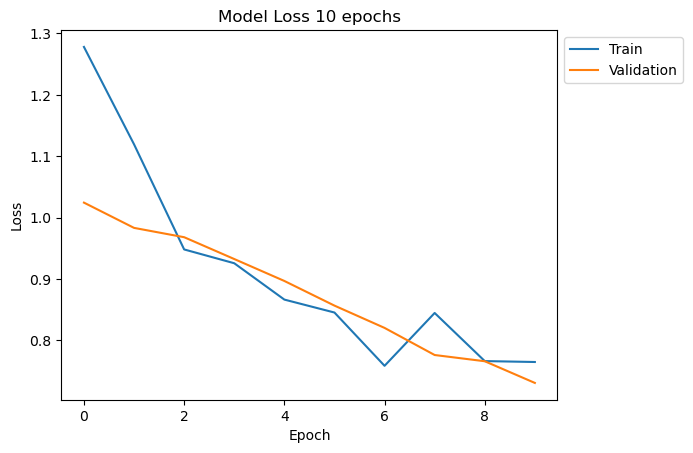

In [15]:
#Plot model loss
plt.plot(model_history101.history['loss'])
plt.plot(model_history101.history['val_loss'])
plt.title('Model Loss 10 epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

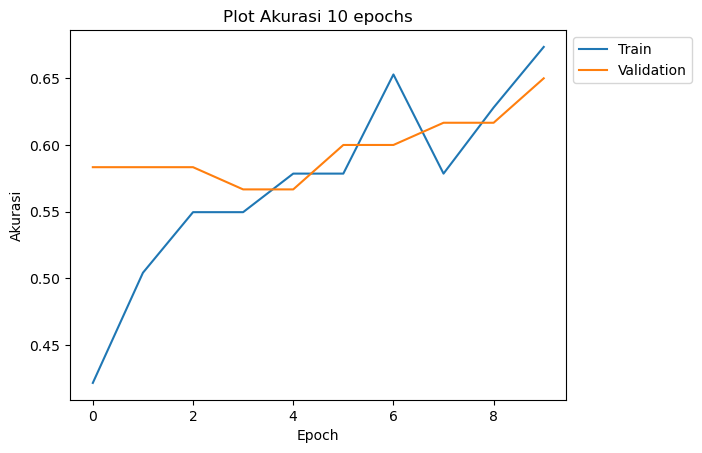

In [16]:
#Plot model akurasi
plt.plot(model_history101.history['accuracy'])
plt.plot(model_history101.history['val_accuracy'])
plt.title('Plot Akurasi 10 epochs')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [13]:
#Melakukan pelatihan model 20 epochs
model_history20=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.1818 - accuracy: 0.3967
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik20epochs.keras
25/25 [==============================] - 70s 2s/step - loss: 1.1818 - accuracy: 0.3967 - val_loss: 1.0304 - val_accuracy: 0.4667
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.9078 - accuracy: 0.5744
Epoch 2: val_accuracy improved from 0.46667 to 0.61667, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik20epochs.keras
25/25 [==============================] - 61s 2s/step - loss: 0.9078 - accuracy: 0.5744 - val_loss: 0.9360 - val_accuracy: 0.6167
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.9008 - accuracy: 0.6116
Epoch 3: val_accuracy improved from 0.61667 to 0.66667, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik20epochs.keras
25/25 [==============================] - 63

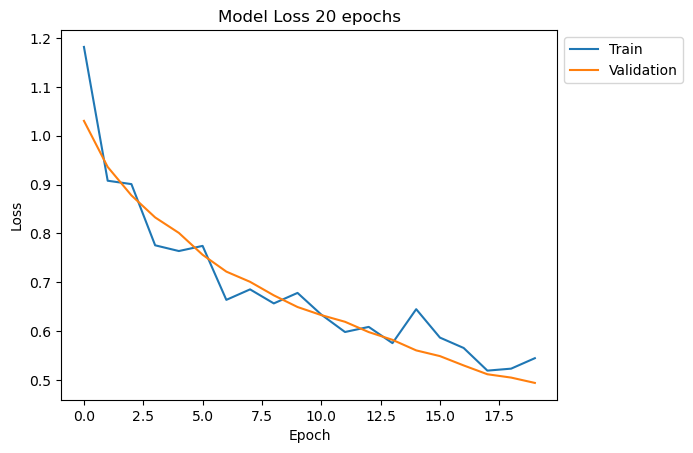

In [15]:
#Plot model loss
plt.plot(model_history20.history['loss'])
plt.plot(model_history20.history['val_loss'])
plt.title('Model Loss 20 epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

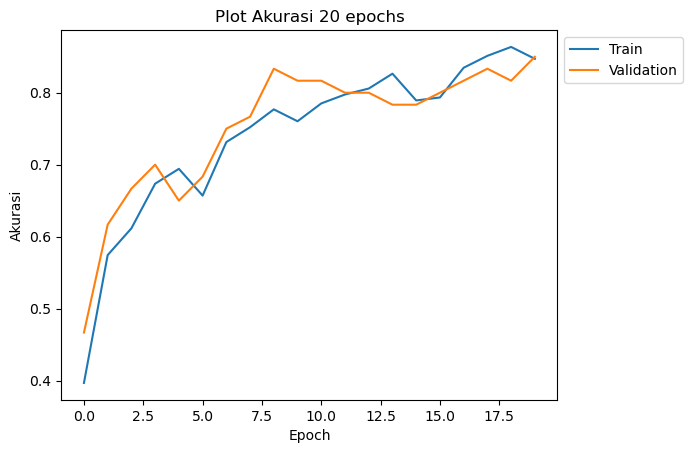

In [16]:
#Plot model akurasi
plt.plot(model_history20.history['accuracy'])
plt.plot(model_history20.history['val_accuracy'])
plt.title('Plot Akurasi 20 epochs')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [19]:
#Melakukan pelatihan model 30 epochs
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 30,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.9127 - accuracy: 0.5496
Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik.keras
25/25 [==============================] - 78s 3s/step - loss: 0.9127 - accuracy: 0.5496 - val_loss: 0.8976 - val_accuracy: 0.6500
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.6570
Epoch 2: val_accuracy improved from 0.65000 to 0.76667, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik.keras
25/25 [==============================] - 71s 3s/step - loss: 0.7941 - accuracy: 0.6570 - val_loss: 0.8246 - val_accuracy: 0.7667
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.6322
Epoch 3: val_accuracy improved from 0.76667 to 0.80000, saving model to C:\Users\LENOVO\Documents\training-model\jenisplastik.keras
25/25 [==============================] - 71s 3s/step - loss: 0.7731

Epoch 29/30
25/25 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8802
Epoch 29: val_accuracy did not improve from 0.93333
25/25 [==============================] - 69s 3s/step - loss: 0.4158 - accuracy: 0.8802 - val_loss: 0.3503 - val_accuracy: 0.9000
Epoch 30/30
25/25 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.8884
Epoch 30: val_accuracy did not improve from 0.93333
25/25 [==============================] - 70s 3s/step - loss: 0.4059 - accuracy: 0.8884 - val_loss: 0.3512 - val_accuracy: 0.9167


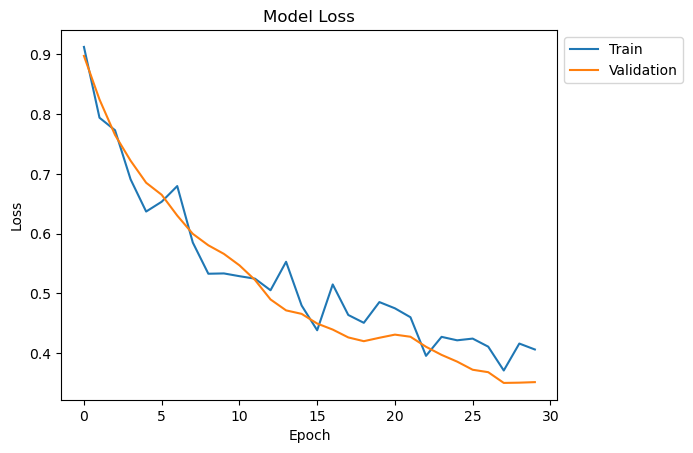

In [21]:
#Plot model loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

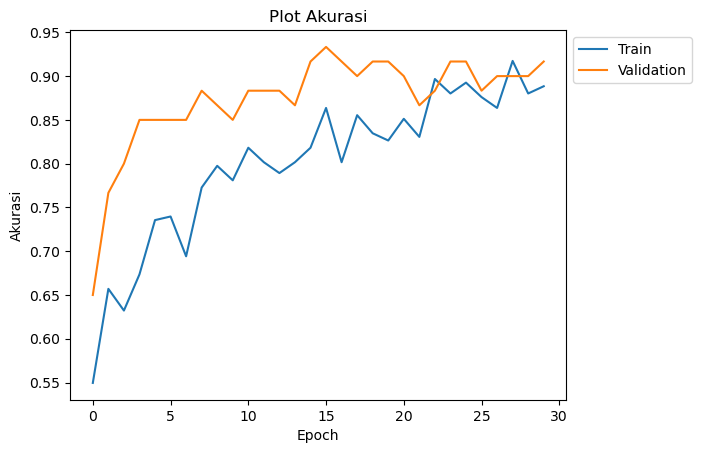

In [22]:
#Plot model akurasi
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Plot Akurasi')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
#Menyimpan model epoch terakhir
model.save(r'C:\Users\LENOVO\Documents\training-model\jenisplastik1.keras')

In [15]:
sm =  tf.keras.models.load_model(r'C:\Users\LENOVO\Documents\training-model\jenisplastik1.keras')

In [12]:
sm0 =  tf.keras.models.load_model(r'C:\Users\LENOVO\Documents\training-model\jenisplastik.keras')

In [17]:
sm1 =  tf.keras.models.load_model(r'C:\Users\LENOVO\Documents\training-model\jenisplastik10epochs(1).keras')

In [24]:
sm2 =  tf.keras.models.load_model(r'C:\Users\LENOVO\Documents\training-model\jenisplastik20epochs.keras')

In [96]:
loss, acc = sm.evaluate(train_dataset, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

25/25 - 93s - loss: 0.1771 - accuracy: 1.0000 - 93s/epoch - 4s/step
Restored model, accuracy: 100.00%


In [21]:
#Melakukan test pada data baru
test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)
test_data = test_datagen.flow_from_directory(directory = r'C:\Users\LENOVO\Downloads\test_plastik',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             shuffle = False,
                                             batch_size = 10)

Found 273 images belonging to 3 classes.


In [33]:
test_data.class_indices

{'hdpe': 0, 'ldpe': 1, 'pet': 2}

In [26]:
#Melihat akurasi,presisi, dan recall model menggunakan data validasi
from sklearn.metrics import classification_report

predictions = sm0.predict(test_data)
true_labels = test_data.classes
class_indices = test_data.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=list(class_labels.values()))
print("Classification Report:\n", report)

28/28 [==============================] - 83s 3s/step
Classification Report:
               precision    recall  f1-score   support

        hdpe       0.82      0.36      0.50        90
        ldpe       0.28      0.59      0.38        34
         pet       0.77      0.84      0.80       149

    accuracy                           0.65       273
   macro avg       0.62      0.59      0.56       273
weighted avg       0.73      0.65      0.65       273



In [97]:
#Evaluasi model pada data validasi
loss, acc = sm.evaluate(valid_dataset, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

6/6 [==============================] - 21s 3s/step - loss: 0.3512 - accuracy: 0.9167
Restored model, accuracy: 91.67%


In [100]:
#Evaluasi model pada test (data baru)
loss, acc = sm.evaluate(test_data, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

28/28 [==============================] - 69s 2s/step - loss: 0.9017 - accuracy: 0.6447
Restored model, accuracy: 64.47%


6/6 [==============================] - 14s 2s/step


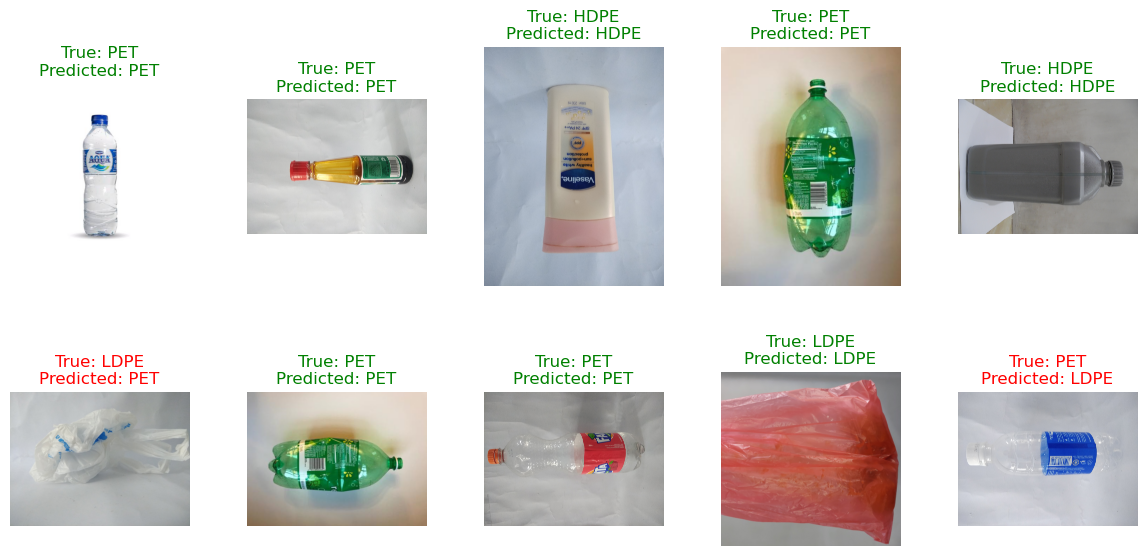

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class_names = list(valid_dataset.class_indices.keys())

# Get predictions on the validation dataset
y_pred = sm.predict(valid_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = valid_dataset.classes

# Select random images for display
num_images = 10
random_indices = np.random.choice(len(valid_dataset.filepaths), size=num_images, replace=False)

# Plot the images with predicted and true labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.tight_layout()
for i, idx in enumerate(random_indices):
    img_path = valid_dataset.filepaths[idx]
    img = plt.imread(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    true_label = class_names[y_true_labels[idx]]
    pred_label = class_names[y_pred_labels[idx]]
    title_color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}\nPredicted: {pred_label}', color=title_color)

plt.show()

In [29]:
#Melihat akurasi,presisi, dan recall model menggunakan data validasi
from sklearn.metrics import classification_report

predictions = sm0.predict(valid_dataset)
true_labels = valid_dataset.classes
class_indices = valid_dataset.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=list(class_labels.values()))
print("Classification Report:\n", report)

6/6 [==============================] - 23s 3s/step
Classification Report:
               precision    recall  f1-score   support

        HDPE       1.00      0.85      0.92        20
        LDPE       1.00      0.95      0.97        20
         PET       0.83      1.00      0.91        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



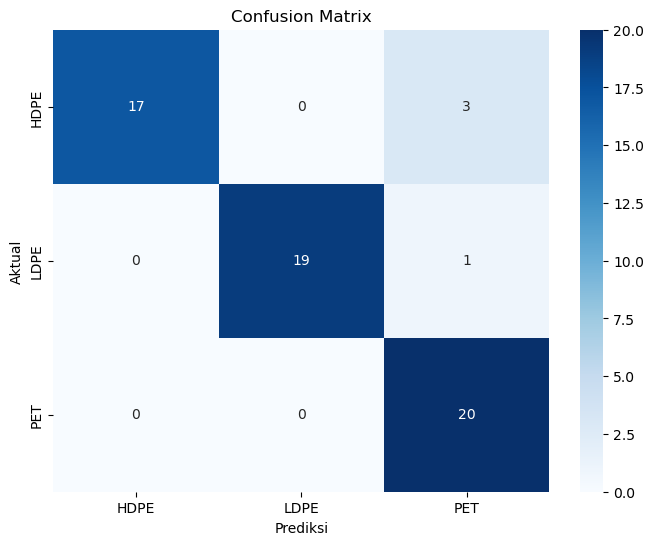

In [30]:
#Matriks konfusi model dari data validasi
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [21]:
#Melihat akurasi,presisi, dan recall model menggunakan data validasi
from sklearn.metrics import classification_report

predictions = sm1.predict(valid_dataset)
true_labels = valid_dataset.classes
class_indices = valid_dataset.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=list(class_labels.values()))
print("Classification Report:\n", report)

6/6 [==============================] - 25s 4s/step
Classification Report:
               precision    recall  f1-score   support

        HDPE       0.50      0.90      0.64        20
        LDPE       0.90      0.95      0.93        20
         PET       0.67      0.10      0.17        20

    accuracy                           0.65        60
   macro avg       0.69      0.65      0.58        60
weighted avg       0.69      0.65      0.58        60



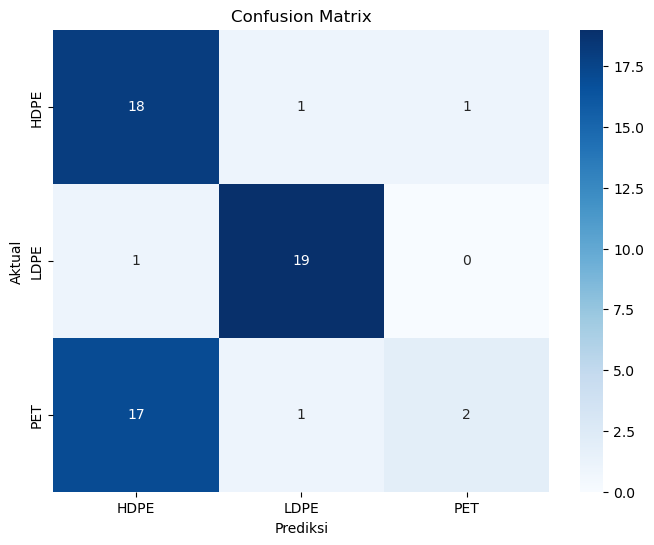

In [22]:
#Matriks konfusi model dari data validasi
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [33]:
#Melihat akurasi,presisi, dan recall model menggunakan data validasi
from sklearn.metrics import classification_report

predictions = sm2.predict(valid_dataset)
true_labels = valid_dataset.classes
class_indices = valid_dataset.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=list(class_labels.values()))
print("Classification Report:\n", report)

6/6 [==============================] - 22s 3s/step
Classification Report:
               precision    recall  f1-score   support

        HDPE       0.89      0.80      0.84        20
        LDPE       0.78      0.90      0.84        20
         PET       0.89      0.85      0.87        20

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



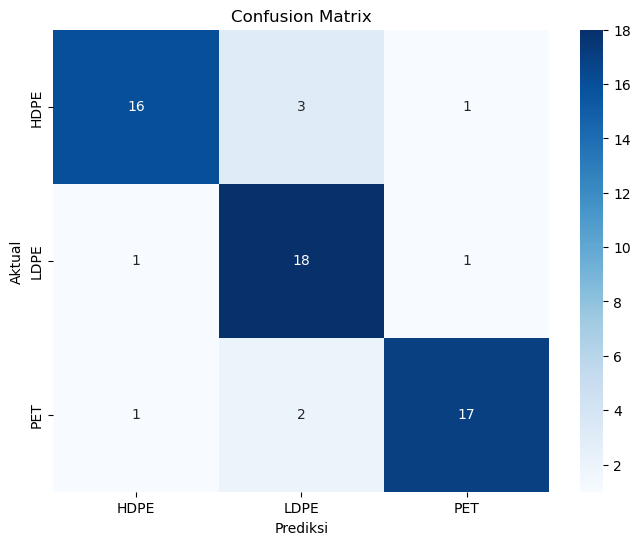

In [34]:
#Matriks konfusi model dari data validasi
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

1/1 [==============================] - 2s 2s/step
Gambar ini diprediksi sebagai: HDPE


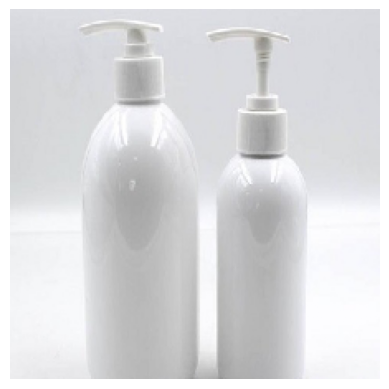

In [13]:
#Melakukan uji coba dengan input gambar
from pylab import *
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2
# Fungsi untuk melakukan prediksi gambar
def predict_image(model, image_path, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Ganti ukuran target sesuai dengan model Anda
    img = img_to_array(img)
    img = img / 255  # Normalisasi
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img, axis=0)

    predictions = sm0.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Daftar nama kelas
class_labels = ['HDPE', 'LDPE', 'PET']

# Input gambar dari pengguna
image_path = r'C:\Users\LENOVO\Downloads\test_plastik\hdpe\botol-sampo-plastik-hdpe-2_2.jpeg'

# Melakukan prediksi
predicted_class = predict_image(model, image_path, class_labels)
print("Gambar ini diprediksi sebagai:", predicted_class)

1/1 [==============================] - 0s 453ms/step
Gambar ini diprediksi sebagai: LDPE


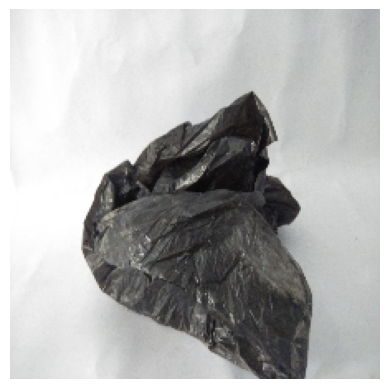

In [21]:
from pylab import *
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2
# Fungsi untuk melakukan prediksi gambar
def predict_image(model, image_path, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Ganti ukuran target sesuai dengan model Anda
    img = img_to_array(img)
    img = img / 255  # Normalisasi
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img, axis=0)

    predictions = sm0.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Daftar nama kelas
class_labels = ['HDPE', 'LDPE', 'PET']

# Input gambar dari pengguna
image_path = r'C:\Users\LENOVO\Downloads\test_plastik\ldpe\IMG_20191229_141451.jpg'

# Melakukan prediksi
predicted_class = predict_image(model, image_path, class_labels)
print("Gambar ini diprediksi sebagai:", predicted_class)

1/1 [==============================] - 0s 345ms/step
Gambar ini diprediksi sebagai: PET


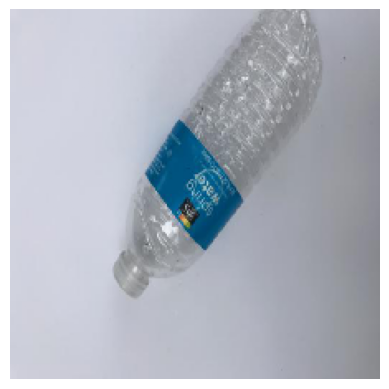

In [22]:
from pylab import *
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2
# Fungsi untuk melakukan prediksi gambar
def predict_image(model, image_path, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Ganti ukuran target sesuai dengan model Anda
    img = img_to_array(img)
    img = img / 255  # Normalisasi
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img, axis=0)

    predictions = sm0.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Daftar nama kelas
class_labels = ['HDPE', 'LDPE', 'PET']  # Ganti dengan nama kelas yang sesuai

# Input gambar dari pengguna
image_path = r'C:\Users\LENOVO\Downloads\test_plastik\pet\plastic75.jpg'

# Melakukan prediksi
predicted_class = predict_image(model, image_path, class_labels)
print("Gambar ini diprediksi sebagai:", predicted_class)

1/1 [==============================] - 0s 338ms/step
Gambar ini diprediksi sebagai: PET


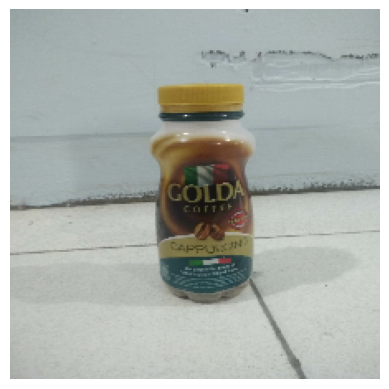

In [23]:
from pylab import *
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2
# Fungsi untuk melakukan prediksi gambar
def predict_image(sm, image_path, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Ganti ukuran target sesuai dengan model Anda
    img = img_to_array(img)
    img = img / 255  # Normalisasi
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img, axis=0)

    predictions = sm0.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

# Daftar nama kelas
class_labels = ['HDPE', 'LDPE', 'PET']  # Ganti dengan nama kelas yang sesuai

# Input gambar dari pengguna
image_path = r'C:\Users\LENOVO\Downloads\WhatsApp Image 2023-11-27 at 09.04.50.jpeg'

# Melakukan prediksi
predicted_class = predict_image(sm, image_path, class_labels)
print("Gambar ini diprediksi sebagai:", predicted_class)